In [1]:
# IMPORTS
from bertopic import BERTopic
import pandas as pd
import os

# helper functions
from helper_functions import get_relevant_topics
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Helper functions
from helper_functions import create_lag_df
from helper_functions import plot_ConfusionMatrix

/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nop

In [2]:
df_news = pd.read_csv("data/articles_topics.csv", parse_dates=["date"])
df_food_crisis = pd.read_csv("data/food_crises_cleaned.csv", parse_dates=['date'])

In [3]:
# df_food_crisis = df_food_crisis[(df_news['date'] >= '2009-07-01') & (df_news['date'] <= '2020-03-01')]

In [4]:
districts = list(region for region in df_food_crisis["district"].unique())
for i in range(len(districts)):
    districts[i] = districts[i].replace("Center", "").replace("South", "").replace("North", "").replace("East", "").replace("West", "").strip()
districts = list(dict.fromkeys(districts))

In [5]:
districts

['Bor',
 'Jur River',
 'Aweil',
 'Morobo',
 'Magwi',
 'Kajo Keji',
 'Ikotos',
 'Yei',
 'Yambio',
 'Ibba',
 'Lainya',
 'Maridi',
 'Anzara',
 'Kapoeta',
 'Budi',
 'Torit',
 'Juba',
 'Mundri',
 'Lafon',
 'Ezo',
 'Terekeka',
 'Mvolo',
 'Awerial',
 'Nagero',
 'Yirol',
 'Tambura',
 'Wau',
 'Pibor',
 'Wulu',
 'Rumbek',
 'Twic',
 'Cueibet',
 'Pochalla',
 'Tonj',
 'Akobo',
 'Panyijiar',
 'Duk',
 'Uror',
 'Ulang',
 'Nasir',
 'Leer',
 'Mayendit',
 'Maiwut',
 'Ayod',
 'Koch',
 'Gogrial',
 'Nyirol',
 'Pigi',
 'Mayom',
 'Abiemnhom',
 'Longchuk',
 'Fangak',
 'Maban',
 'Guit',
 'Pariang',
 'Rubkona',
 'Panyikang',
 'Raja',
 'Baliet',
 'Fashoda',
 'Manyo',
 'Melut',
 'Renk',
 'Malakal']

In [9]:
count = 0

for district in districts:
    count += len(df_news[df_news['paragraphs'].str.contains(district)])
    print(f"The number of articles related to {district}: {len(df_news[df_news['paragraphs'].str.contains(district)])}")

print(f"--{count}")

The number of articles related to Bor: 2156
The number of articles related to Jur River: 26
The number of articles related to Aweil: 324
The number of articles related to Morobo: 54
The number of articles related to Magwi: 75
The number of articles related to Kajo Keji: 31
The number of articles related to Ikotos: 20
The number of articles related to Yei: 389
The number of articles related to Yambio: 190
The number of articles related to Ibba: 8
The number of articles related to Lainya: 40
The number of articles related to Maridi: 65
The number of articles related to Anzara: 4
The number of articles related to Kapoeta: 85
The number of articles related to Budi: 20
The number of articles related to Torit: 260
The number of articles related to Juba: 10887
The number of articles related to Mundri: 46
The number of articles related to Lafon: 3
The number of articles related to Ezo: 17
The number of articles related to Terekeka: 42
The number of articles related to Mvolo: 9
The number of ar

In [10]:
df_news['districts'] = np.nan
df_news['districts'] = df_news['districts'].astype('object')
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18296 entries, 0 to 18295
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         18296 non-null  object        
 1   date          18296 non-null  datetime64[ns]
 2   paragraphs    18296 non-null  object        
 3   publisher     18296 non-null  object        
 4   hunger        18296 non-null  bool          
 5   refugees      18296 non-null  bool          
 6   humanitarian  18296 non-null  bool          
 7   conflict      18296 non-null  bool          
 8   districts     0 non-null      object        
dtypes: bool(4), datetime64[ns](1), object(4)
memory usage: 786.3+ KB


In [11]:
df_news_districted = pd.DataFrame(columns=df_news.columns)
df_news_districted

,title,date,paragraphs,publisher,hunger,refugees,humanitarian,conflict,districts


In [12]:
from tqdm.notebook import tqdm
counter = 0

for i in tqdm(range(len(df_news))):
    counter = 0
    for district in districts:
        if district in df_news.iloc[i, 2]:
            df_news_districted = pd.concat([df_news_districted, df_news.iloc[i:i+1]], axis=0)
            df_news_districted.iloc[-1, -1] = district
            counter += 1
    if(counter == 0):
        for district in districts:
            df_news_districted = pd.concat([df_news_districted, df_news.iloc[i:i+1]], axis=0)
            df_news_districted.iloc[-1, -1] = district

  0%|          | 0/18296 [00:00<?, ?it/s]

In [18]:
df_news_districted
df_news_districted.to_csv("data/df_news_districted.csv")

In [11]:
df_food_crisis[df_food_crisis['ipc'].notnull()]

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date
42,South Sudan,74,Bor,32.00486,6.465644,2010_07,2010,7,2.0,NaN,...,-1.655068,0,0,1.251864,14008.3300,7.961984,265263.0,11393.760,90.8503,2010-07-01
45,South Sudan,74,Bor,32.00486,6.465644,2010_10,2010,10,2.0,NaN,...,2.328747,0,0,1.278539,14008.3300,7.961984,265263.0,11393.760,90.8503,2010-10-01
48,South Sudan,74,Bor,32.00486,6.465644,2011_01,2011,1,1.0,NaN,...,0.610770,1,0,1.266479,14008.3300,7.961984,271467.0,11393.760,90.8503,2011-01-01
63,South Sudan,74,Bor,32.00486,6.465644,2012_04,2012,4,2.0,0.0,...,1.602302,1,0,2.355737,14008.3300,7.961984,277671.0,11393.760,90.8503,2012-04-01
66,South Sudan,74,Bor,32.00486,6.465644,2012_07,2012,7,2.0,0.0,...,5.980510,0,0,2.208810,14008.3300,7.961984,277671.0,11393.760,90.8503,2012-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12307,South Sudan,151,Malakal,31.64280,9.658457,2018_10,2018,10,3.0,1.0,...,-1.224320,0,0,53.934660,757.7855,13.068690,118402.0,7145.909,85.5000,2018-10-01
12311,South Sudan,151,Malakal,31.64280,9.658457,2019_02,2019,2,3.0,0.0,...,0.031929,0,0,60.114030,757.7855,13.068690,102228.0,7145.909,85.5000,2019-02-01
12315,South Sudan,151,Malakal,31.64280,9.658457,2019_06,2019,6,3.0,1.0,...,1.992628,0,0,69.429000,757.7855,13.068690,102228.0,7145.909,85.5000,2019-06-01
12319,South Sudan,151,Malakal,31.64280,9.658457,2019_10,2019,10,3.0,0.0,...,6.053181,1,0,82.872570,757.7855,13.068690,102228.0,7145.909,85.5000,2019-10-01


In [12]:
df_news[(df_news['date'] > "2009-06-12") & (df_news['date'] < "2020-03-01")]

,title,date,paragraphs,publisher,districts
1,South Sudan: #budget2019 - Will It Lead to Mor...,2019-02-21,Legal claims against the department now amount...,Bhekisisa (Johannesburg),NaN
2,South Sudan: Retired NBA Star Elected Basketba...,2019-11-25,Former NBA star Luol Ajou Deng has been electe...,The East African (Nairobi),Duk
5,South Sudan: Adut Akech Fuming After Australia...,2019-08-26,Cape Town — South Sudanese-Australian model Ad...,allAfrica.com,NaN
9,South Sudan: Raila Odinga Offers to Be Mediator,2018-06-06,Former Kenyan Prime Minister Raila Odinga said...,"Voice of America (Washington, DC)",Juba
14,South Sudan: The 'Executioner' Who Would Kill ...,2019-05-05,Reports of torture and killings by South Sudan...,The Nation (Nairobi),Juba Tonj Gogrial
...,...,...,...,...,...
18220,East Africa: IGAD Extraordinary Ministerial Me...,2014-08-14,An Extraordinary IGAD Council of Ministers Mee...,Ethiopian Radio and Television Agency (Addis A...,Juba
18222,South Sudan: Reporter Kidnapped and Tortured T...,2016-03-08,Reporters Without Borders (RSF) condemns the a...,Reporters sans Frontières (Paris),Bor Juba
18223,South Sudan: Lakes - Five People Shot in Rumbe...,2013-07-16,Rumbek — Members of South Sudan's police and a...,Sudan Tribune,Rumbek
18224,Uganda: Education Still Eludes Refugees in Uganda,2014-04-24,"Rhino Camp — Emmanuel Peter Gai, a secondary s...",Sudan Tribune,NaN


In [10]:
article_per_region = []

def check_all(sentence, ws):
    found = []
    for w in ws:
        if(w in sentence):
            found.append(w)
    return found

for i in range(len(df_news)):
    article_per_region.append(check_all(df_news["summary"][i], districts))

rr = []
region_dict = {}
for regions in article_per_region:
    for region in regions:
        rr.append(region)

for r in rr:
    region_dict[r] = region_dict.get(r, 0) + 1

for i,j in dict(sorted(region_dict.items(), key=lambda x: -x[1])).items():
    print(f"Region: {i} -- {j}")
len(region_dict)

KeyError: 'summary'

In [ ]:
df_food_crisis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11482 entries, 1 to 12323
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   country          11482 non-null  object        
 1   district_code    11482 non-null  int64         
 2   district         11482 non-null  object        
 3   centx            11482 non-null  float64       
 4   centy            11482 non-null  float64       
 5   year_month       11482 non-null  object        
 6   year             11482 non-null  int64         
 7   month            11482 non-null  int64         
 8   ipc              2817 non-null   float64       
 9   ha               2024 non-null   float64       
 10  ndvi_mean        11482 non-null  float64       
 11  ndvi_anom        11482 non-null  float64       
 12  rain_mean        11482 non-null  float64       
 13  rain_anom        11482 non-null  float64       
 14  et_mean          11482 non-null  float

In [ ]:
df_food_crisis.groupby('year').apply(lambda x: x.isnull().sum()).reset_index()


ValueError: cannot insert year, already exists

In [ ]:
df_food_crisis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11482 entries, 1 to 12323
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   country          11482 non-null  object        
 1   district_code    11482 non-null  int64         
 2   district         11482 non-null  object        
 3   centx            11482 non-null  float64       
 4   centy            11482 non-null  float64       
 5   year_month       11482 non-null  object        
 6   year             11482 non-null  int64         
 7   month            11482 non-null  int64         
 8   ipc              2817 non-null   float64       
 9   ha               2024 non-null   float64       
 10  ndvi_mean        11482 non-null  float64       
 11  ndvi_anom        11482 non-null  float64       
 12  rain_mean        11482 non-null  float64       
 13  rain_anom        11482 non-null  float64       
 14  et_mean          11482 non-null  float

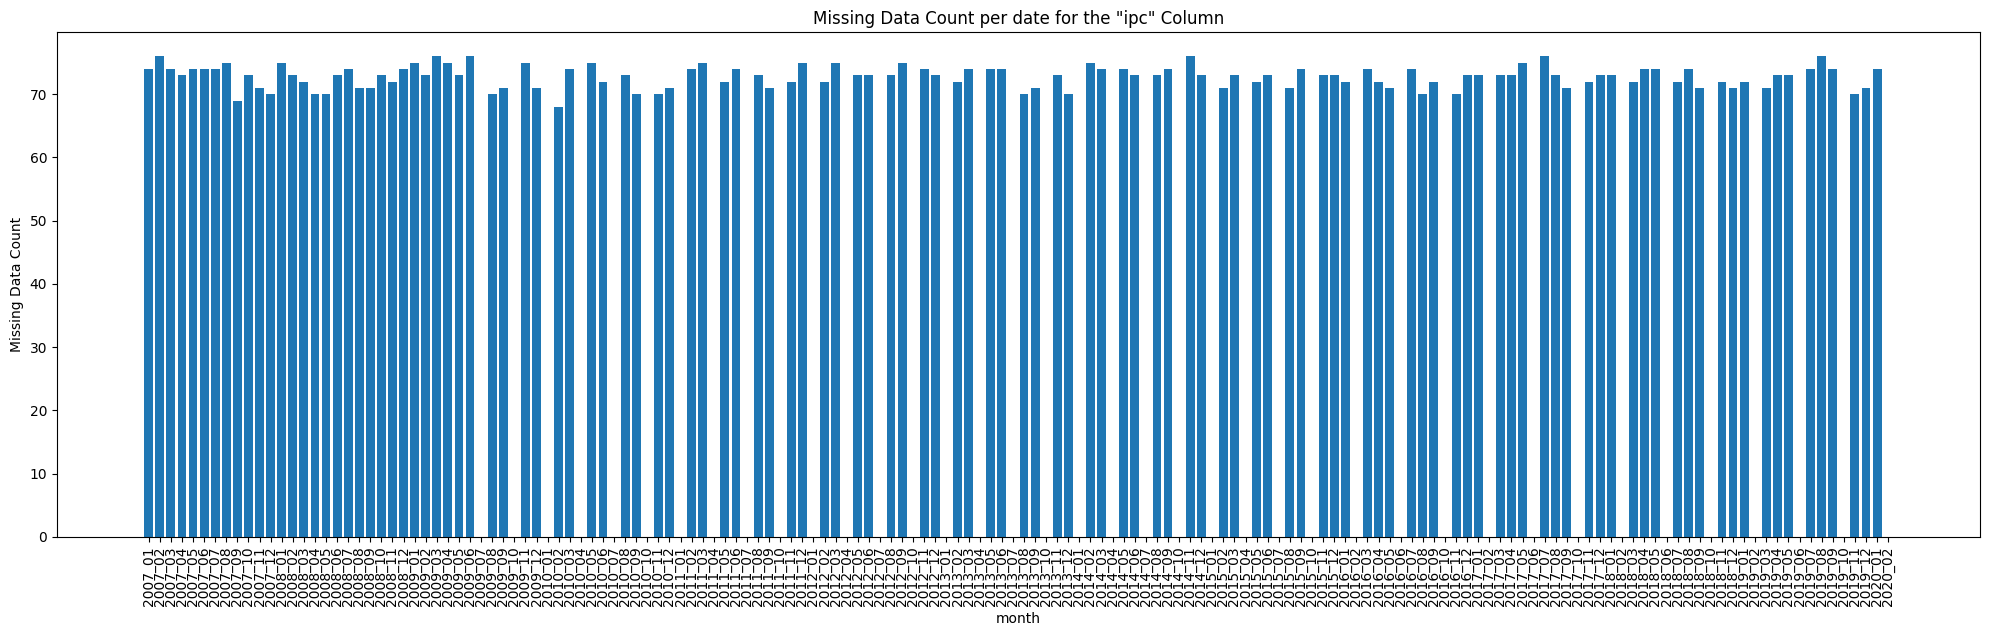

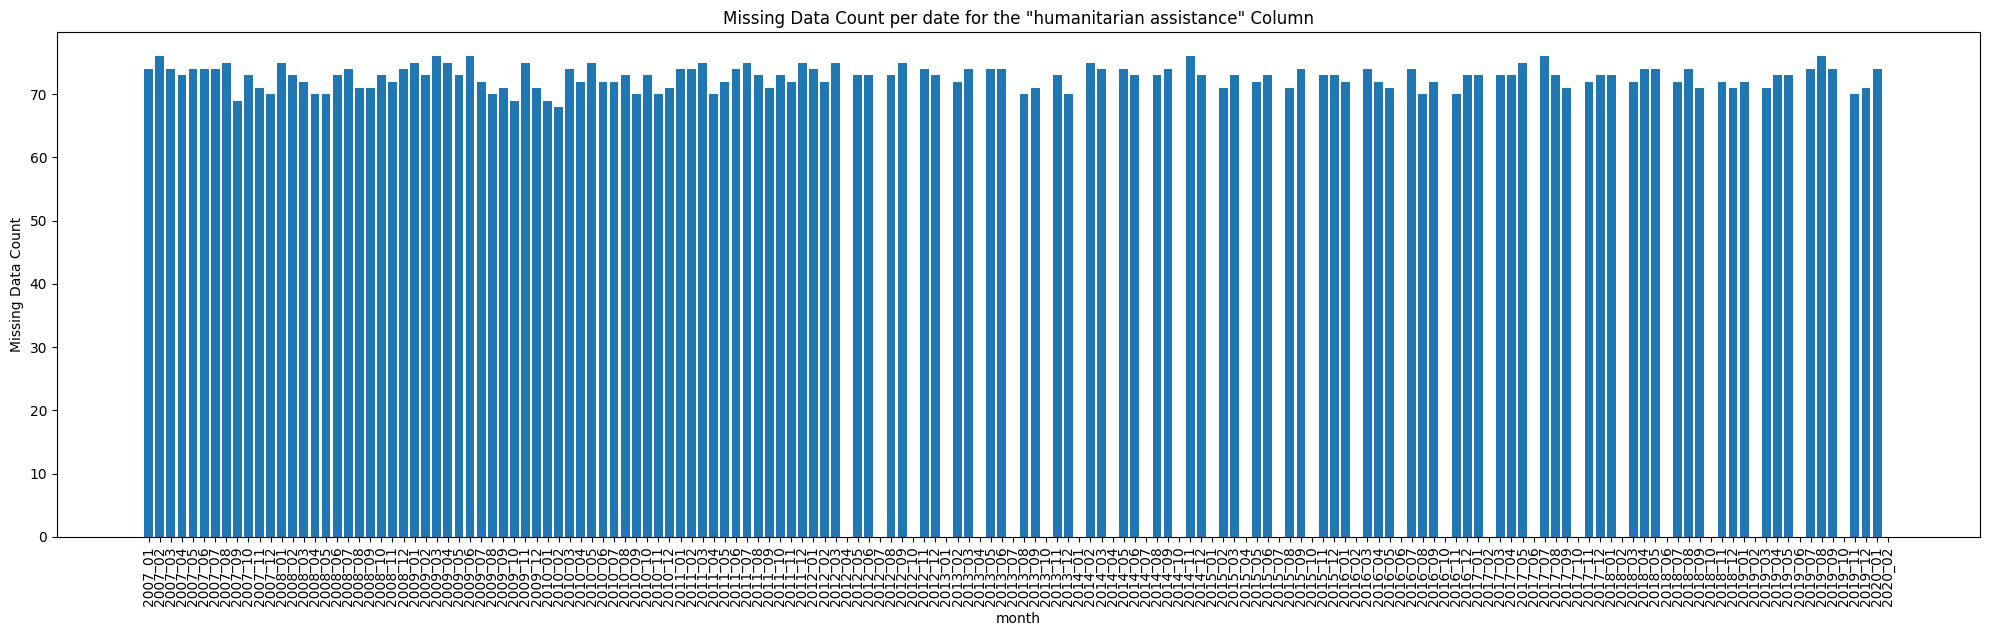

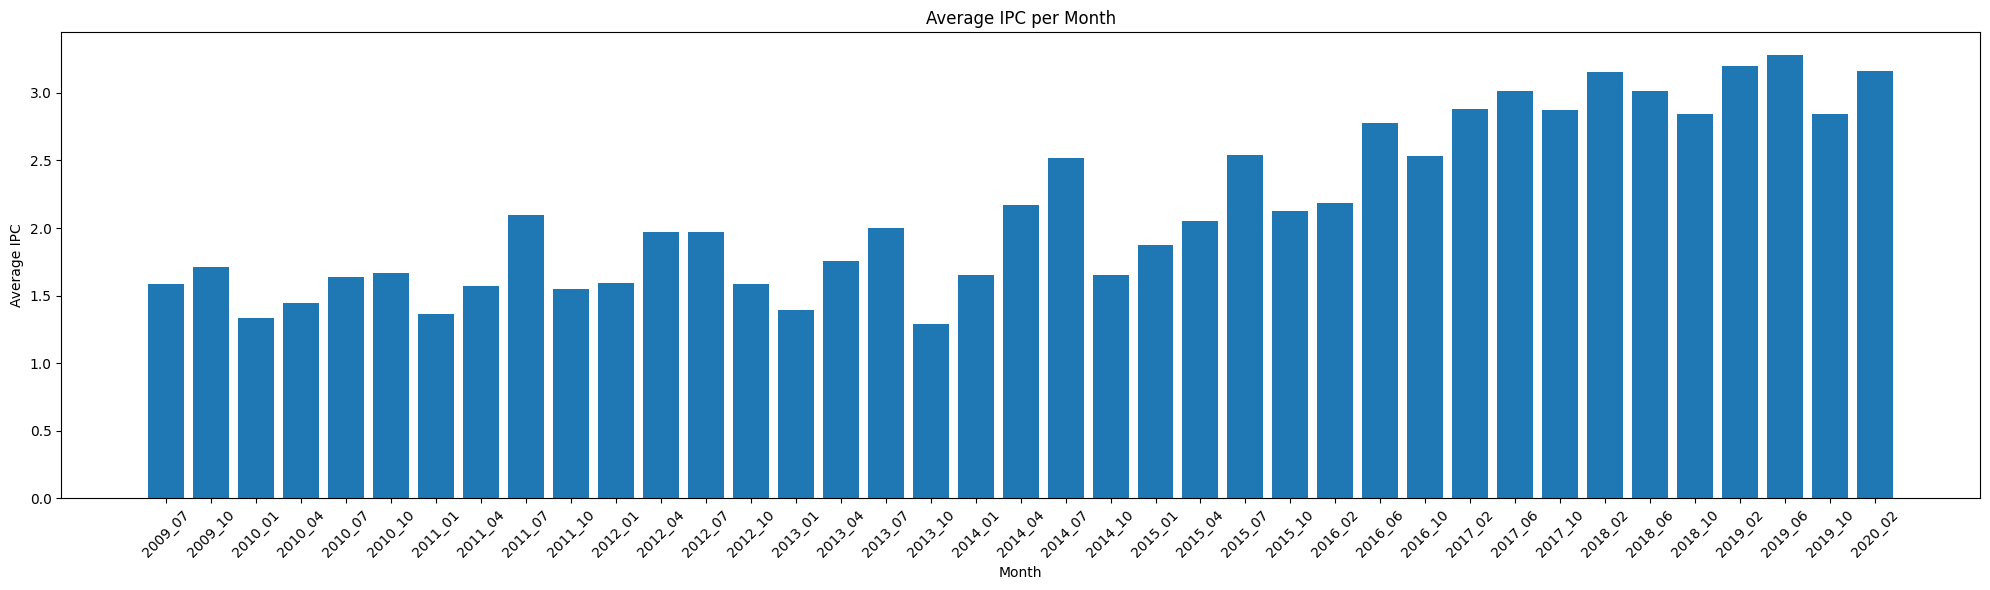

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by year and calculate the count of missing values
missing_data_per_year = df_food_crisis.groupby(df_food_crisis['year_month'])['ipc'].apply(lambda x: x.isnull().sum()).reset_index()

# Rename columns for clarity
missing_data_per_year.columns = ['date', 'missing_count']

# Create a bar chart
plt.figure(figsize=(20, 6))
plt.bar(missing_data_per_year['date'], missing_data_per_year['missing_count'])
plt.xlabel('month')
plt.ylabel('Missing Data Count')
plt.title('Missing Data Count per date for the "ipc" Column')

#----------------------

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# Group by year and calculate the count of missing values
missing_data_per_year = df_food_crisis.groupby(df_food_crisis['year_month'])['ha'].apply(lambda x: x.isnull().sum()).reset_index()

# Rename columns for clarity
missing_data_per_year.columns = ['date', 'missing_count']

# Create a bar chart
plt.figure(figsize=(20, 6))
plt.bar(missing_data_per_year['date'], missing_data_per_year['missing_count'])
plt.xlabel('month')
plt.ylabel('Missing Data Count')
plt.title('Missing Data Count per date for the "humanitarian assistance" Column')


plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

# Group by month and calculate the average 'ipc' for each month
monthly_avg_ipc = df_food_crisis.groupby(df_food_crisis[df_food_crisis['ipc'].notnull()]['year_month'])['ipc'].mean()


# Create a bar chart
plt.figure(figsize=(20, 6))
plt.bar(monthly_avg_ipc.index, monthly_avg_ipc)
plt.xlabel('Month')
plt.ylabel('Average IPC')
plt.title('Average IPC per Month')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
len(missing_data_per_year[missing_data_per_year['missing_count'] == 0])

39

In [ ]:
df_news[(df_news['date'].dt.year == 2019) & (df_news['date'].dt.year == 2019)]

,title,date,paragraphs,publisher,districts
1,South Sudan: #budget2019 - Will It Lead to Mor...,2019-02-21,Legal claims against the department now amount...,Bhekisisa (Johannesburg),NaN
2,South Sudan: Retired NBA Star Elected Basketba...,2019-11-25,Former NBA star Luol Ajou Deng has been electe...,The East African (Nairobi),NaN
5,South Sudan: Adut Akech Fuming After Australia...,2019-08-26,Cape Town — South Sudanese-Australian model Ad...,allAfrica.com,NaN
14,South Sudan: The 'Executioner' Who Would Kill ...,2019-05-05,Reports of torture and killings by South Sudan...,The Nation (Nairobi),NaN
19,South Sudan: Lack of Power Lines Hurts South S...,2019-08-31,South Sudan's chance to be the first major con...,The East African (Nairobi),NaN
...,...,...,...,...,...
18075,South Sudan: Leaders Urged to End Displacement...,2019-07-13,The United Nations (UN) Refugee Agency (UNHCR)...,Ghanaian Times (Accra),NaN
18094,South Sudan Starts Anxious 100-Day Countdown t...,2019-11-10,The countdown to 100 days for South Sudan's an...,The East African (Nairobi),NaN
18120,South Sudan: The U.S. Ambassador to Juba and M...,2019-05-12,"Juba, 8 May 2017 - Alice Baku (not real name) ...",World Health Organization (Geneva),NaN
18174,South Sudan: Peace Pact Intact Despite Bashir ...,2019-04-21,Months of protests in Sudan led to the ousting...,The Monitor (Kampala),NaN


In [ ]:
counter = 0
for i in article_per_region:
    if(len(i) == 0):
        counter+=1
counter

12022

In [ ]:
len(article_per_region) - counter

5782

## Assigning articles to regions in South Sudan

In [ ]:
import geopandas as gpd

south_sudan_gj = gpd.read_file("south-sudan-with-regions_.geojson")

## Feature extraction

In [ ]:
# IMPORTS
from bertopic import BERTopic
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer

# helper functions
from helper_functions import get_relevant_topics

In [ ]:
docs = df_news["summary"].to_list()

In [ ]:
vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words="english")

model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', calculate_probabilities=True,
    verbose=True
)

topics, probs = model.fit_transform(docs)


Batches:   0%|          | 0/557 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
freq = model.get_topic_info()
freq.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6414,-1_sudan_south_article_south sudan,"[sudan, south, article, south sudan, discusses...",[The article discusses a security deal between...
1,0,459,0_independence_author_tribalism_challenges,"[independence, author, tribalism, challenges, ...",[The article discusses the declaration of inde...
2,1,452,1_refugees_refugee_unhcr_sudanese refugees,"[refugees, refugee, unhcr, sudanese refugees, ...",[The article discusses the increasing number o...
3,2,359,2_journalists_media_freedom_radio,"[journalists, media, freedom, radio, press, in...",[The article discusses the arrest of four jour...
4,3,244,3_border_zone_agreements_sudan south,"[border, zone, agreements, sudan south, implem...",[The article discusses the UN Secretary-Genera...


In [ ]:
model.visualize_topics()

In [ ]:
model.visualize_hierarchy()

### 1. Embedding

The first step is embedding with a sequence transformer model. The model requires fine tuning, we'll use sentence transformer form the `sentence-transformers` library

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

Then we create the embeddings

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm

BATCH_SIZE = 1
n=len(docs)

embeds = np.zeros((n, model.get_sentence_embedding_dimension()))

for i in tqdm(range(0, n, BATCH_SIZE)):
    i_end = min(i + BATCH_SIZE, n)
    batch = docs[i:i_end]
    batch_embed =  model.encode(batch)
    embeds[i:i_end, :] = batch_embed

  0%|          | 0/17804 [00:00<?, ?it/s]

Onto dim reduction and clustering

### UMAP Dimensionality reduction

We'll start by testing several UMAP parameters and visualizing results.

In [ ]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, 
                 min_dist=0.0, metric='cosine', random_state=42)
topic_model = BERTopic(umap_model=umap_model)

  0%|          | 0/12 [00:00<?, ?it/s]

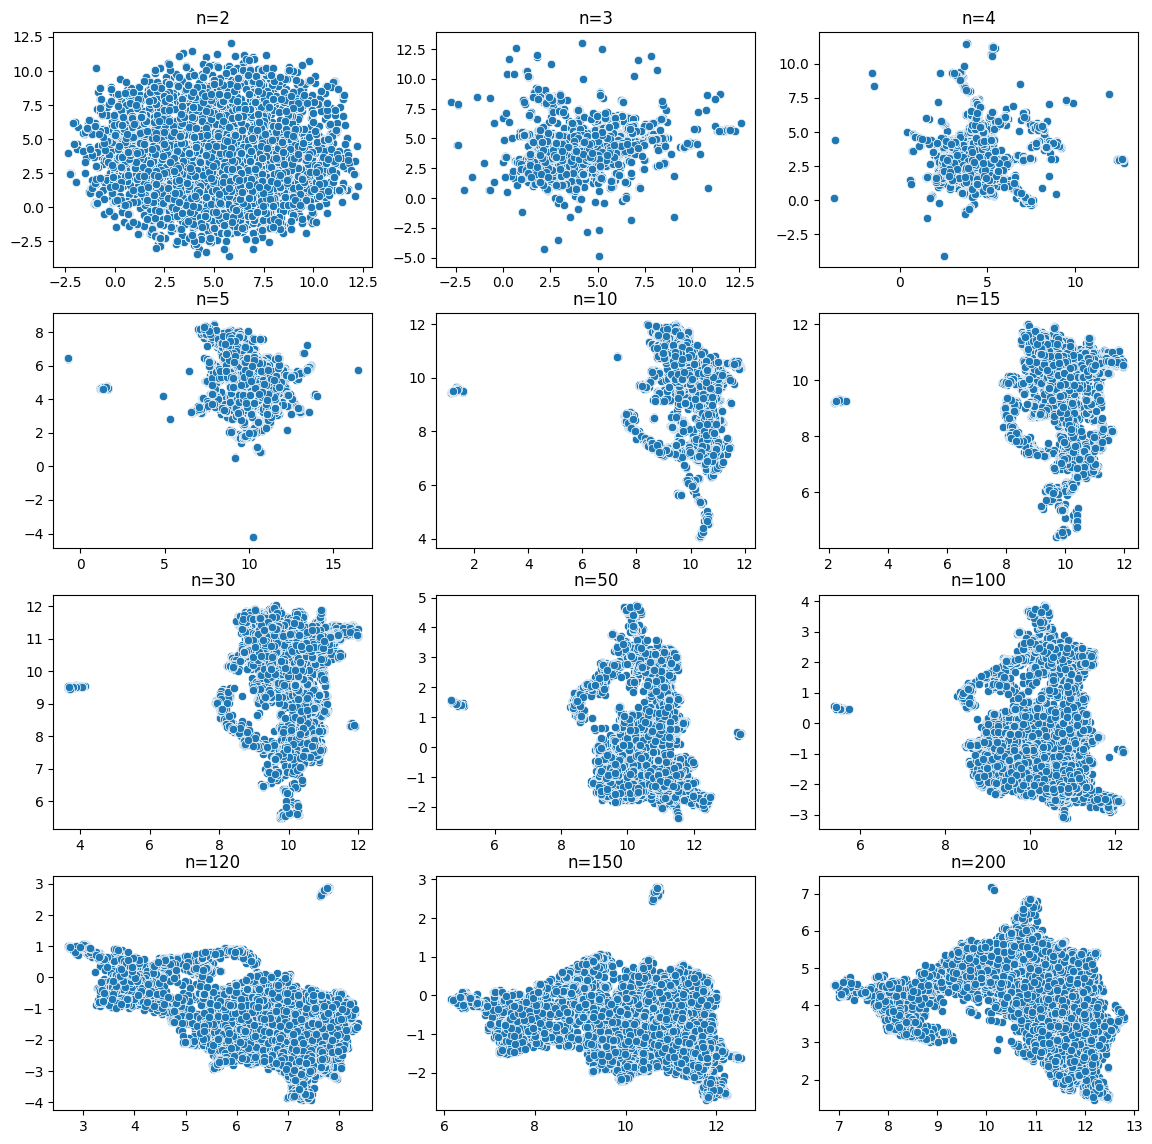

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(4,3, figsize= (14,14))
nns = [2,3,4,5,10,15,30,50,100, 120, 150, 200]
i,j = 0,0

for n_neighbours in tqdm(nns):
    fit = UMAP(n_neighbors=n_neighbours, n_components=5, 
                 min_dist=0.0, metric='cosine')
    u = fit.fit_transform(embeds)
    sns.scatterplot(x=u[:,0], y=u[:,1], ax=ax[j,i])
    ax[j,i].set_title(f'n={n_neighbours}')
    if i < 2: i+=1
    else: i = 0; j +=1

### Clustering with HDBSCAN

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(u)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

HDBSCAN()

<Axes: ylabel='$\\lambda$ value'>

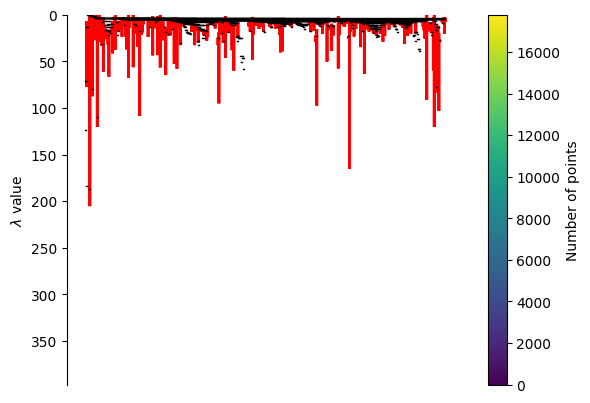

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True)

<Axes: ylabel='$\\lambda$ value'>

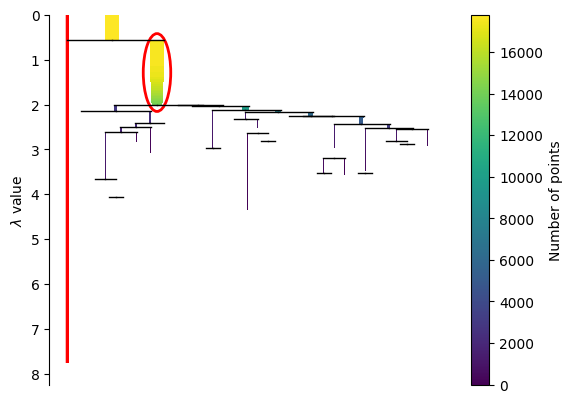

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=110
)
clusterer.fit(u)

clusterer.condensed_tree_.plot(select_clusters=True)